# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np
from collections import deque
import torch

from ddpg_agent import Agent

import matplotlib.pyplot as plt
%matplotlib inline

import platform

In [2]:
filename = ''
if 'linux' in platform.system().lower():
        print('Linux')
        filename = 'Reacher.x86_64'

if 'darwin' in platform.system().lower():
        print('Mac')
        filename = 'Reacher.app'

if 'windows' in platform.system().lower(): # Not tested
        print('Win')
        filename = 'Reacher.exe'


assert filename != '', "Please write the correct filename (and path if needed) to the Tennis application in the cell below and uncomment."

# Please write the correct filename (and path if needed) to the Tennis application
# filename = ''

env = UnityEnvironment(file_name=filename)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Multi Agent Deep Deterministic Policy Gradient aka MADDPG

In [5]:
# Whether to run the environment in training or inference mode
# Training mode is faster than inference mode, visualization-wise.
train_mode = True

In [6]:
agent = Agent(state_size=state_size, action_size=action_size, random_seed=10, num_agents=num_agents)

In [7]:
def ddpg(n_episodes=300, max_t=1000):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
    """
    
    all_episodes_scores = []                                     # list containing scores from each episode
    scores_window = deque(maxlen=100)                            # last 100 scores
    first_time = False
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=train_mode)[brain_name]
        states = env_info.vector_observations
        agent.reset()
        score_list = np.zeros(num_agents) # score for the episode <--- before [] and issue with score_list == 0.00. TODO why?
        
        for t in range(max_t):
            actions = agent.act(states) # No need to clip as act return clipped actions between -1 and 1
            
            env_info = env.step(actions)[brain_name]           # send the action to the environment
            next_states = env_info.vector_observations
            rewards = env_info.rewards                         # get the reward
            dones = env_info.local_done                        # see if episode has finished
            
            agent.step(states, actions, rewards, next_states, dones)
            states = next_states
            score_list += rewards
            
            if np.any(dones):
                break
                
        avg_ep_score = np.mean(score_list) # Average episode score
        scores_window.append(avg_ep_score) # Last 100 episodes
        
        all_episodes_scores.append(avg_ep_score)
        print('\rEpisode {}\tEpisode Score: {:.2f}\tTotal Average Score: {:.2f}\tLast 100nth Score: {:.2f}'.format(i_episode, 
                                                                                        avg_ep_score, 
                                                                                        np.mean(all_episodes_scores),
                                                                                        np.mean(scores_window)
                                                                                       ), end="")
        if avg_ep_score >= 0.5 and not first_time:
            print('\rFirst episode to reach 0.5+ {}\tEpisode Score: {:.2f}\tTotal Average Score: {:.2f}\tLast 100nth Score: {:.2f}'.format(i_episode, 
                                                                                                                avg_ep_score, 
                                                                                                                np.mean(all_episodes_scores),
                                                                                                                np.mean(scores_window)))
            first_time = True
        if i_episode % 100 == 0:
            print('\rEpisode {}\tEpisode Score: {:.2f}\tTotal Average Score: {:.2f}\tLast 100nth Score: {:.2f}'.format(i_episode, 
                                                                                            avg_ep_score, 
                                                                                            np.mean(all_episodes_scores),
                                                                                            np.mean(scores_window)))
        if np.mean(scores_window) >= 0.5:
            if i_episode >= 100:
                print('\nEnvironment solved after {:d} episodes!\tAverage last 100 Episodes Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
                torch.save(agent.actor_local.state_dict(), 'checkpoint_actor_in-{}_s-{}.pth'.format(i_episode, np.mean(scores_window)))
                torch.save(agent.critic_local.state_dict(), 'checkpoint_critic_in-{}_s-{}.pth'.format(i_episode, np.mean(scores_window)))
                break

    return all_episodes_scores

In [8]:
import time
start = time.time()

In [9]:
print("Number of agents {}".format(num_agents))
scores = ddpg(n_episodes=5000, max_t=1000)

Number of agents 2
Episode 5	Episode Score: -0.00	Total Average Score: -0.00	Last 100nth Score: -0.00

/home/m_destephe/.virtualenvs/rlnano/lib/python3.6/site-packages/torch/nn/functional.py:1374: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode 100	Episode Score: -0.00	Total Average Score: -0.00	Last 100nth Score: -0.00
Episode 200	Episode Score: 0.10	Total Average Score: -0.00	Last 100nth Score: 0.00
Episode 300	Episode Score: -0.00	Total Average Score: 0.00	Last 100nth Score: 0.01
Episode 400	Episode Score: 0.05	Total Average Score: 0.01	Last 100nth Score: 0.02
Episode 500	Episode Score: 0.10	Total Average Score: 0.02	Last 100nth Score: 0.06
First episode to reach 0.5+ 510	Episode Score: 0.95	Total Average Score: 0.02	Last 100nth Score: 0.07
Episode 600	Episode Score: 0.35	Total Average Score: 0.04	Last 100nth Score: 0.15
Episode 682	Episode Score: 0.70	Total Average Score: 0.10	Last 100nth Score: 0.50
Environment solved after 682 episodes!	Average last 100 Episodes Score: 0.50


In [10]:
end = time.time() - start
print("The training was done in {:.2f} seconds.".format(end))

The training was done in 447.75 seconds.


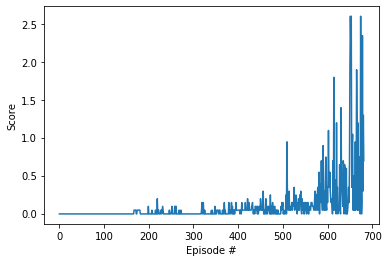

In [11]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

When finished, you can close the environment.

In [12]:
env.close()